# Probabilistic supervised classification with scikit-learn

In this notebook, I am using Python library **scikit-learn** to train and evaluate some probabilistic supervised classification algorithms: Logistic regression, Linear discriminant analysis and Gaussian Naive Bayes, along with Random Forests metaclassifier.

## Data loading

The <a href="https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.">data</a> was obtained from UCI repository.

Target variable in this dataset is **class**, which contains information about whether an individual is suffering or not diabetes. For convenience, this variable will be renamed later to **Diabetes**.

Also, there are sixteen predictor variables: **Age**, **Gender** and fourteen symptoms or conditions associated to diabetes. The aim of this work was to improve the early detection of this disease, because there is a lot of people suffering diabetes that remains undiagnosed.

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("diabetes.csv")
dataset.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In the next piece of code, I'm encoding all `"Yes"`, `"Male"` and `"Positive"` to **`1`**, and their complementaries `"No"`, `"Female"` and `"Negative"` to **`0`**. The reason I am doing this is to prepare a table that numerically describes all columns in the dataset, and this encoding allows the computation of the proportion of individuals in each level (two levels in all cases) of the categorical features in this dataset.

In [2]:
for _ in range(dataset.shape[0]):
    
    for column in dataset.columns[1:]:
        if dataset[column][_] in ["Male", "Yes", "Positive"]:
            dataset[column][_] = 1
        else:
            dataset[column][_] = 0

dataset = dataset.rename(columns={"class": "Diabetes",
                                  "sudden weight loss": "Sudden weight loss",
                                  "weakness": "Weakness",
                                  "visual blurring": "Visual blurring", 
                                  "delayed healing": "Delayed healing",
                                  "partial paresis": "Partial paresis",
                                  "muscle stiffness": "Muscle stiffness"})
dataset = dataset.astype("int64")          
del column

<ipython-input-2-c2b8e5663fc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column][_] = 1
<ipython-input-2-c2b8e5663fc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column][_] = 0


## Exploratory data analysis

This is the summary table I have mentioned before. In row called **mean**, we can see the proportion of individuals in the "Yes"/"Male"/"Positive" group of each categorical variable. For **Age** feature, it shows the real mean in this column because this is the only continuous variable.

In [3]:
round(dataset.describe(), 2)

,Age,Gender,Polyuria,Polydipsia,Sudden weight loss,Weakness,Polyphagia,Genital thrush,Visual blurring,Itching,Irritability,Delayed healing,Partial paresis,Muscle stiffness,Alopecia,Obesity,Diabetes
count,520.00,520.00,520.0,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00
mean,48.03,0.63,0.5,0.45,0.42,0.59,0.46,0.22,0.45,0.49,0.24,0.46,0.43,0.38,0.34,0.17,0.62
std,12.15,0.48,0.5,0.50,0.49,0.49,0.50,0.42,0.50,0.50,0.43,0.50,0.50,0.48,0.48,0.38,0.49
min,16.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,39.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,47.50,1.00,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,57.00,1.00,1.0,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00
max,90.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Next, I am visualizing this dataset. I have considered more appropriate to represent this data as a kind of histogram: for **Age** variable this histogram will have 10 bins, while for the rest of variables the bin value is set to 3 (so as to show a bar for each level in the categorical variable, separated by a certain empty space).

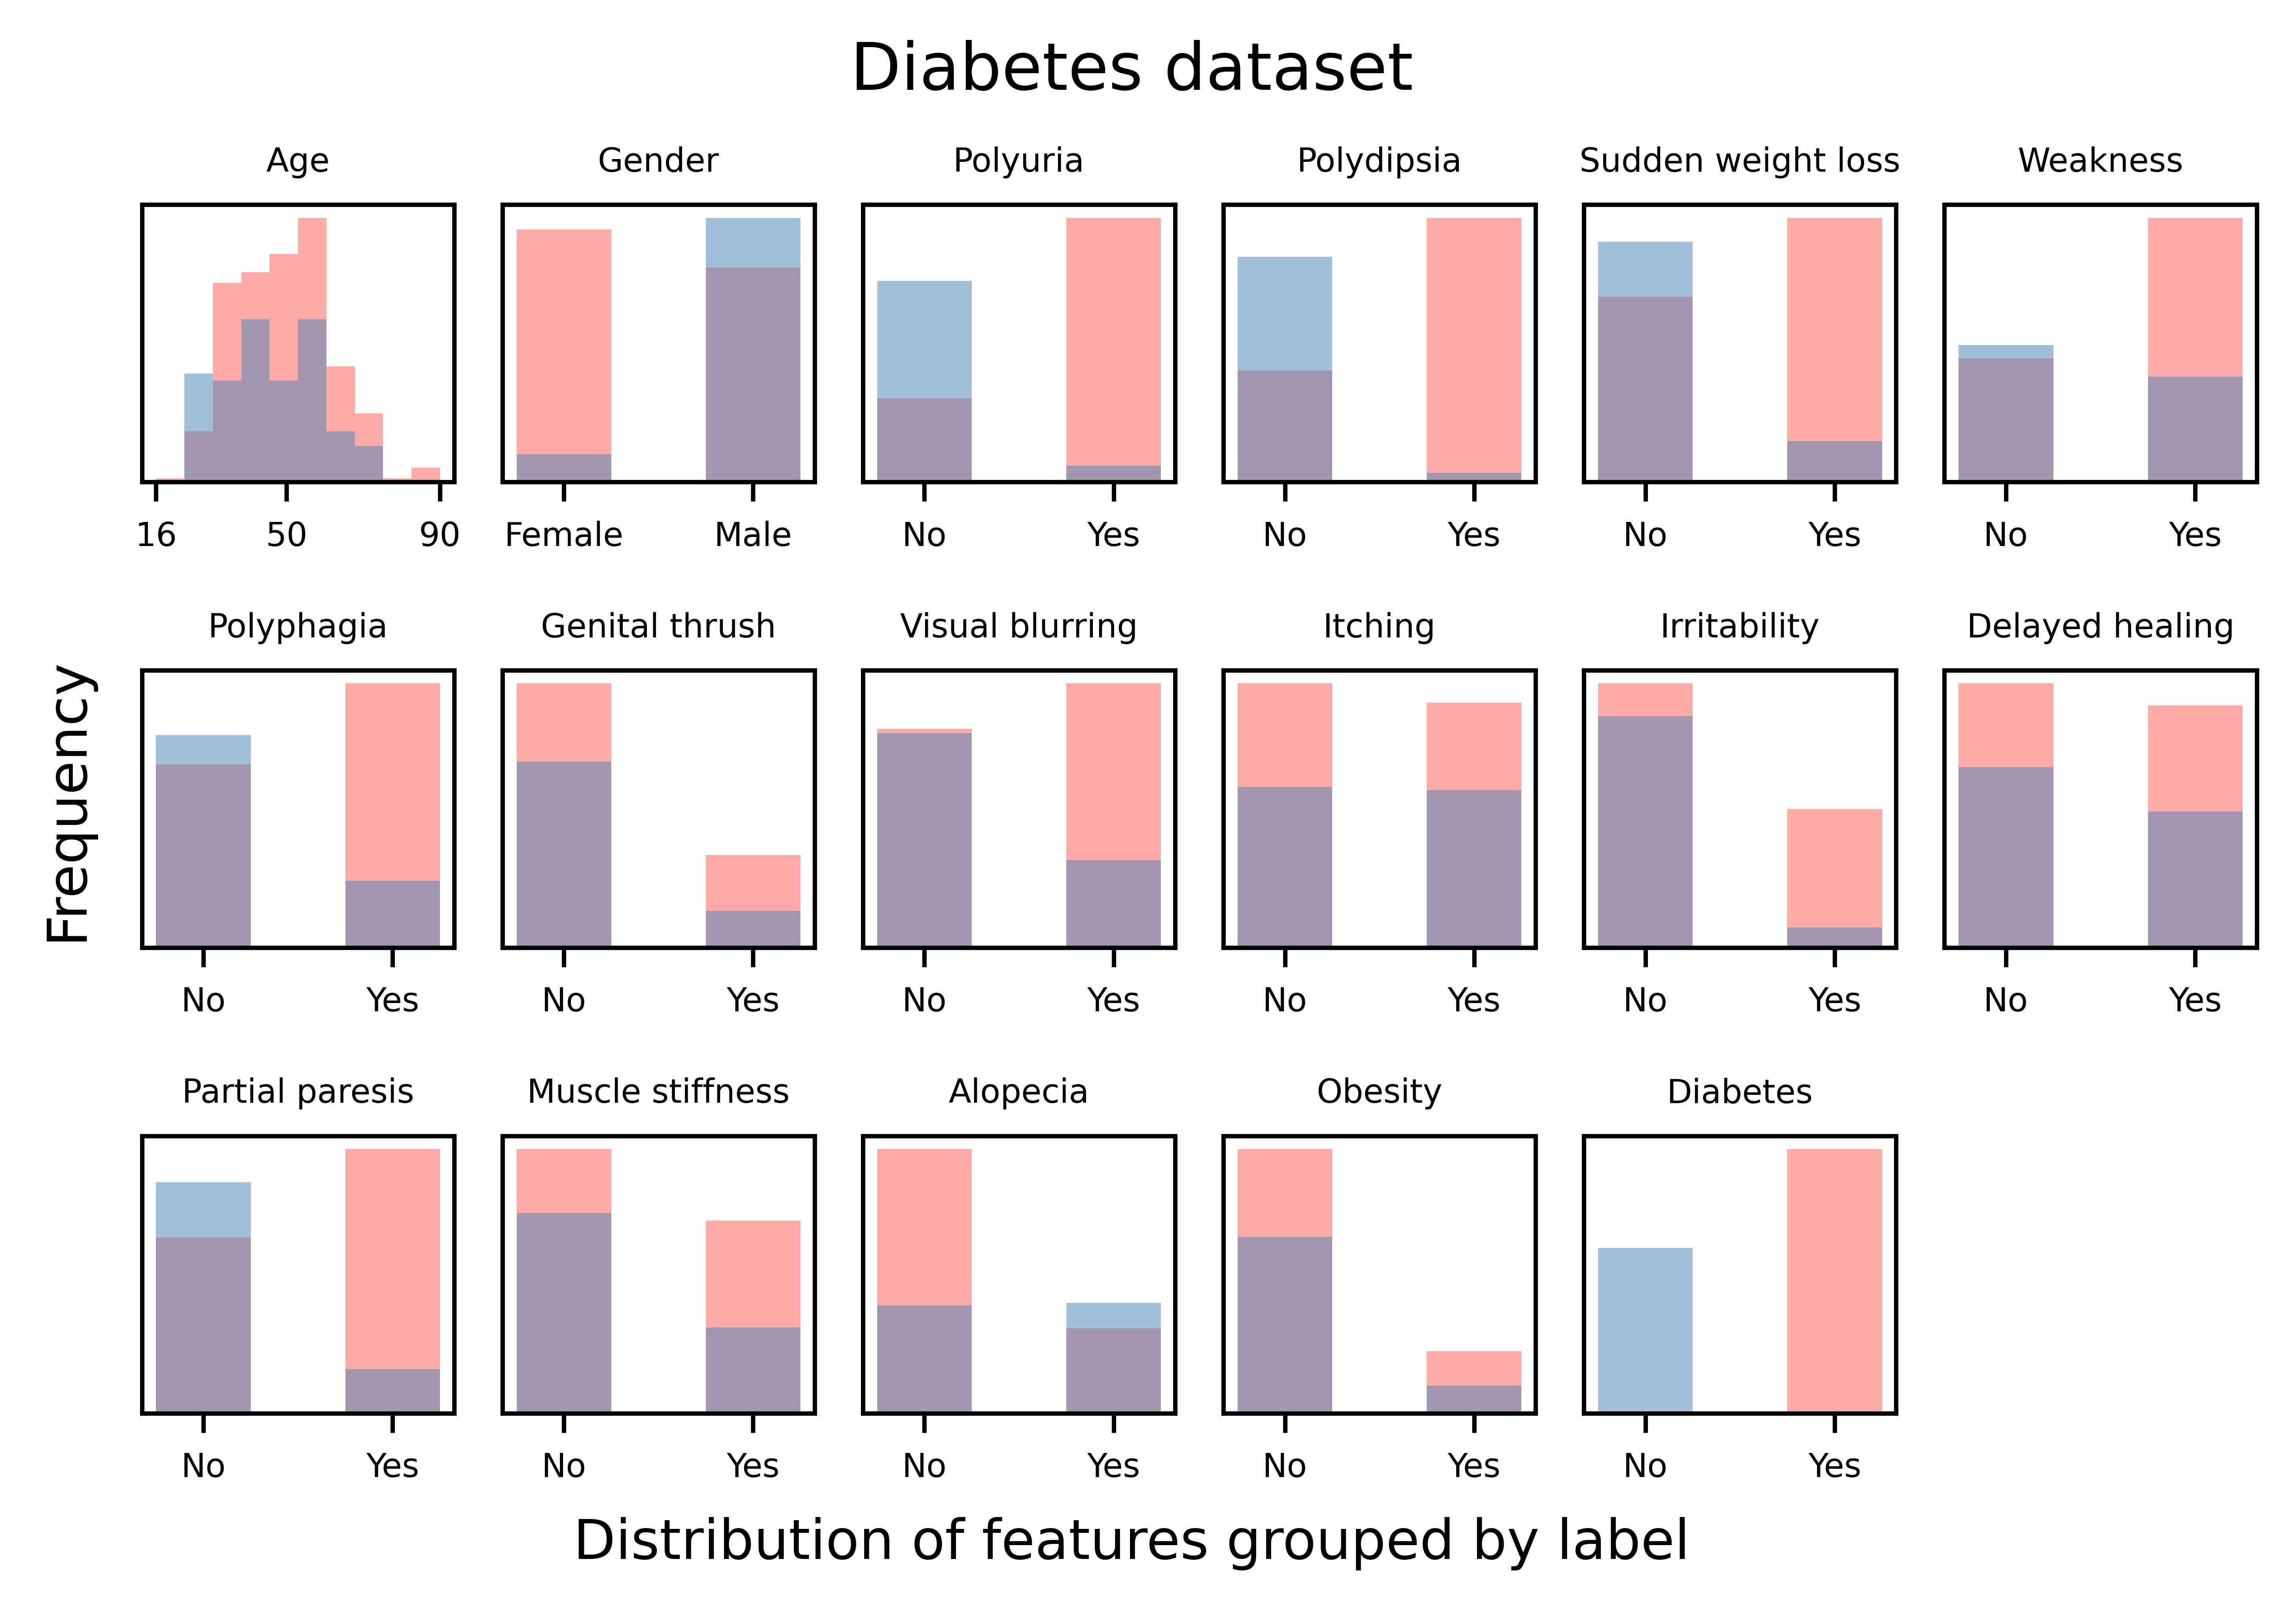

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 6,  dpi=1000)
# a and b are two counters, which are useful to locate each subplot in the
#  proper position of the figure.
a = 0 
b = 0

for column in list(dataset.columns):
    # To show differences in the distribution of feature for healthy and diabetes
    # individuals, x1 and x2 are created
    x1 = dataset.loc[dataset.Diabetes==0, column]
    x2 = dataset.loc[dataset.Diabetes==1, column]
    
    # To set the x range of the histogram, m and M are created
    M = dataset[column].max()
    m = dataset[column].min()
    
    # Number of bins is set
    if column == "Age":
        bins = 10
    else:
        bins = 3
    
    # Creation of histograms
    axs[a,b].hist(x2, alpha = 0.5, range = (m, M),density=False, histtype='bar', stacked=True, bins = bins, color='#ff5555')
    axs[a,b].hist(x1, alpha = 0.5, range = (m, M),  density=False, histtype='bar', stacked=True, bins = bins, color='steelblue')
    axs[a,b].set_title(column, fontsize=6)
    axs[a,b].set_ylabel("")
    axs[a,b].set_xlabel("")
    if column == "Age":
        plt.setp(axs[a,b], xticks=[m, 50, M],
            yticks=[]) 
    elif column == "Gender":
        plt.setp(axs[a,b], xticks=[1/6,1-1/6], xticklabels=['Female', 'Male'], yticks=[]) 
    else:
        plt.setp(axs[a,b], xticks=[1/6,1-1/6], xticklabels=['No', 'Yes'],
            yticks=[]) 
    axs[a,b].tick_params(axis='x', labelsize=6)
    #axs[a,b].tick_params(axis='both', which='major', size = 0, labelsize=0, color = "w", labelcolor = "w")
    b+=1

    
    if b == 6:
        b = 0
        a +=1
   
# Hiding the axes in the empty (last) subplot
axs[2,5].set_visible(False)

# Finishing the figure

fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
fig.text(0.5, 0.02, 'Distribution of features grouped by label', ha='center')
fig.suptitle("Diabetes dataset", fontsize = 12)
fig.tight_layout(w_pad=0,rect=[0.05, 0.03, 1, 0.95])
fig.savefig("eda.png")


# Removing objects that will not be used further
del a, axs, b, fig, x1, x2, m, M, column

## Building supervised classifiers

### Splitting of the data in train and test subsets

I am using **train_test_split** from `sklearn.model_selection` to split the data into a train and a test set. The test subset is set to be 30% of the initial data, and random state is set to 0.

In [5]:
from sklearn.model_selection import train_test_split

X = dataset.loc[:, dataset.columns != 'Diabetes']
y = dataset["Diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

For each probabilistic supervised classification algorithm, four analysis have been performed:

- Considering all variables in the dataset.
- Considering only the variables selected by univariate filter.
- Considering only the subset of variables selected by multivariate filter.
- Using a wrapper subset selection approach.

### Univariate filter: Mutual information

As an univariate filter, mutual information of each predictor variable and the target variable has been computed. The variables with the highest score have been added to **X_train_uni** (from **X_train**) and **X_test_uni** (from **X_test**).

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif


chi2select = SelectKBest(mutual_info_classif, k=5).fit(X_train, y_train)
X_train_uni = chi2select.transform(X_train)
X_train_uni_colnames = chi2select.transform([X_train.columns])

X_train_uni = pd.DataFrame(X_train_uni, columns = X_train_uni_colnames[0])

X_test_uni = chi2select.transform(X_test)
X_test_uni_colnames = chi2select.transform([X_test.columns])
X_test_uni = pd.DataFrame(X_test_uni, columns = X_test_uni_colnames[0])

Below, we can see all sixteen variables along with their mutual information score, sorted by this last value. The top 5 features have been selected for this part of the analysis. Note that this selection is independent from the probabilistic supervised classification algorithm used.

In [7]:
order = chi2select.scores_.argsort()

for i in range(len(dataset.columns) - 1):
    print(list(dataset.columns[order])[-i-1], ":", chi2select.scores_[order][-i-1])

Polyuria : 0.26910019105940575
Polydipsia : 0.23424864100016984
Age : 0.16763091823276266
Partial paresis : 0.11125112368718426
Sudden weight loss : 0.09426887095463843
Polyphagia : 0.07620900550265208
Gender : 0.0701204608669046
Obesity : 0.040410813404126555
Alopecia : 0.032614327360693585
Visual blurring : 0.030133670813084823
Irritability : 0.02192460499143012
Delayed healing : 0.01109776691065023
Weakness : 0.010139397849801002
Itching : 0.0022557030992909066
Muscle stiffness : 0.0
Genital thrush : 0.0


### Multivariate filter: RELIEF

Next, the best subset of 5 features was selected using RELIEF algorithm. This subset was composed by the variables whose name is printed.

In [8]:
from ReliefF import ReliefF

fs = ReliefF(n_neighbors=20, n_features_to_keep=5)
X_train_a = X_train.to_numpy()
y_train_a = y_train.to_numpy()


fs.fit_transform(X_train_a, y_train_a)

X_train_multi = pd.DataFrame()
X_test_multi = pd.DataFrame()
print("The best subset of features, select by multivariate filter (RELIEF), is:")
for column in tuple(X.columns[fs.top_features < 5]):
    print(" -",column)
    X_train_multi[column] = X_train[column]
    X_test_multi[column] = X_test[column]


del X_train_a, y_train_a, fs, column

The best subset of features, select by multivariate filter (RELIEF), is:
 - Age
 - Gender
 - Polydipsia
 - Weakness
 - Obesity


### Fitting of the models

The necessary packages to fit all models and evaluate them (analysis with all variables, and only with univariate filter and multivariate filter selected features) were loaded.

In [9]:
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from numpy import mean, std, sqrt

First, all classifiers were created:

In [10]:
lr = LogisticRegression(solver = "liblinear")
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB(var_smoothing = 1e-6)
rf = RandomForestClassifier(max_depth=4, random_state=0)

Next, two useful lists were created to automatize the fitting and evaluate all classifiers with 10-fold cross validation. These were the two lists:

- **tasks** contains the "task" or subset of data to be used for the fitting and evaluation of the models. It also contains a string to indicate the task in a message that is printed to the console.

- **models** contains the classifiers created before, to be fitted with each **tasks** subset of data.

Also, the dictionary called **metrics** is being used to store the metrics of each classifier, to be shown later.

In [11]:
tasks = [[X_train, "All variables"],
         [X_train_uni, "Variables selected by Univariate filter"],
         [X_train_multi, "Variables selected by Multivariate filter"]]

models = [[lr, "Logistic Regression"],
          [lda, "Linear Discriminant Analysis"],
          [gnb, "Gaussian Naive Bayes"],
          [rf, "Random Forests"]]

metrics = {}

And with the following loop, all models are fitted and evaluated:

In [12]:
for model in models:
    # Metrics dictionary is initialized for each algorithm
    metrics[model[1].strip()] = {"": ["Accuracy", "Recall", "F1-score"]}
    for task in tasks:
        # 10-fold cross-validation
        results = cross_validate(model[0], task[0], y_train, cv=10,
                                scoring=('accuracy', 'recall', 'f1'),
                                return_train_score=True, 
                                return_estimator = True)
        
        # Performance scores are printed to the console, below the model and task names
        title = model[1] + " considering " + task[1].lower()
        border = "\n" + "#"*(2*3 + len(title)) + "\n"
        print("{}## {} ##{}".format(border, title, border))
        print("  Accuracy: ", round(mean(results["test_accuracy"]), 3))
        print("    Recall: ", round(mean(results["test_recall"]), 3))
        print("  F1-score: ", round(mean(results["test_f1"]), 3))
        
        # Performance scores are stored in metrics dictionary
        metrics[model[1].strip()][task[1].strip()] = [round(mean(results["test_accuracy"]), 3),
                                                      round(mean(results["test_recall"]), 3),
                                                      round(mean(results["test_f1"]), 3)]
        print("\nCoefficients: ")
        if model[1] in ["Logistic Regression", "Linear Discriminant Analysis"]:
            res_db = pd.DataFrame()
            for i in range(10):
                res_db[i]= results["estimator"][i].coef_[0]
            res_db_fin = pd.DataFrame()
            
            res_db_fin["Mean"] = res_db.mean(axis=1).values
            res_db_fin["St. Dev."] = res_db.std(axis=1).values
            
            
            print(res_db_fin)
            
            print("\n")
        
        elif model[1] == "Gaussian Naive Bayes":
            epsilons = []
            for result in results["estimator"]:
                epsilons.append(result.epsilon_)
            res_theta = pd.DataFrame()
            for i in range(10):
                res_theta[i]= results["estimator"][i].theta_[0]

            
            res_sigma = pd.DataFrame()
            for i in range(10):
                res_sigma[i]= sqrt(results["estimator"][i].sigma_[0])
            res_db_fin = pd.DataFrame()
            
            res_db_fin["Mean(Theta)"] = res_theta.mean(axis=1).values
            res_db_fin["SD(Theta)"] = res_theta.std(axis=1).values
            
            res_db_fin["sqrt(mean(Sigma))"] = res_sigma.mean(axis=1).values
            res_db_fin["SD(Sigma)"] = res_sigma.std(axis=1).values

            print("Epsilon = {} +- {}".format(round(mean(epsilons), 7), round(std(epsilons), 7)))
            print(res_db_fin)
            
            print("\n")
            

del task, res_db_fin, res_db, i, res_sigma, res_theta, result, epsilons


###################################################
## Logistic Regression considering all variables ##
###################################################

  Accuracy:  0.917
    Recall:  0.92
  F1-score:  0.933

Coefficients: 
        Mean  St. Dev.
0  -0.016985  0.002270
1  -2.433161  0.103881
2   2.492688  0.078450
3   2.639624  0.146764
4   0.587686  0.128706
5   0.398861  0.122974
6   0.515737  0.074564
7   1.072734  0.087707
8   0.099729  0.156285
9  -1.026666  0.085076
10  1.428270  0.103298
11 -0.414343  0.134035
12  0.887040  0.075665
13 -0.058383  0.068783
14 -0.259923  0.146438
15  0.042766  0.153497



#############################################################################
## Logistic Regression considering variables selected by univariate filter ##
#############################################################################

  Accuracy:  0.863
    Recall:  0.859
  F1-score:  0.884

Coefficients: 
       Mean  St. Dev.
0 -0.032111  0.001976
1  2.312323  0.113167
2 

Let's explore the performance of these models one by one. Starting with **Logistic regression**:

In [13]:
pd.DataFrame(metrics["Logistic Regression"])

,,All variables,Variables selected by Univariate filter,Variables selected by Multivariate filter
0,Accuracy,0.917,0.863,0.852
1,Recall,0.920,0.859,0.854
2,F1-score,0.933,0.884,0.878


Pretty nice results for the two Logistic regression classifiers which consider all variables and only the ones selected by univariate filter. The best recall is obtained with this second classifier, which demonstrates that a small subset of variables are as informative as all variables combined.

Apart from these performance metrics, it would be convenient to examine the coefficients of these models. This task will be performed in the future.

Now, **Linear discriminant analysis**:

In [14]:
pd.DataFrame(metrics["Linear Discriminant Analysis"])

,,All variables,Variables selected by Univariate filter,Variables selected by Multivariate filter
0,Accuracy,0.877,0.858,0.830
1,Recall,0.841,0.841,0.814
2,F1-score,0.893,0.877,0.855


Surprisingly low recall for the three classifiers, although accuracy and F1-score are high for the classifier that considers all variables.

For Linear discriminant analysis, it would be interesting to examine the variance-covariance matrices of these models. I will do it in the following weeks.

It is time to see **Gaussian Naive Bayes** results:

In [15]:
pd.DataFrame(metrics["Gaussian Naive Bayes"])

,,All variables,Variables selected by Univariate filter,Variables selected by Multivariate filter
0,Accuracy,0.882,0.866,0.849
1,Recall,0.903,0.854,0.854
2,F1-score,0.904,0.886,0.876


The classifier that takes into account only the five variables selected by univariate filter has the best overall performance. Also here, the one that considers only the subset of variables selected by multivariate filter has the worst predictive capacity.

The next step I want to take is to fit a Tree-Augmented Naive Bayes classifer, and see its tree structure to analyze the relationships between attributes.

Finally, let's examine the performance of the **Random Forests** classifiers:

In [16]:
pd.DataFrame(metrics["Random Forests"])

,,All variables,Variables selected by Univariate filter,Variables selected by Multivariate filter
0,Accuracy,0.926,0.888,0.855
1,Recall,0.934,0.867,0.845
2,F1-score,0.940,0.905,0.879


The models considering all variables and only the variables selected by univariate filter have very nice metrics. The one that only considers the subset of features selected by multivariate filter has a very poor predictive power.

As a wrapper approach, I have used Recursive Feature Elimination. It has been used with Logistic regression, Linear discriminant analysis and Random Forests, and not with Gaussian Naive Bayes because this last classifier does not return "coefficients" per se (using GaussianNB with RFE gives an error because of this).

To count how many times each variable has been selected by a wrapper classifier, **hits** dictionary is created.

In [17]:
from sklearn.feature_selection import RFE


for clf in (lr, lda, rf):
    classif_name = str(type(clf)).split(".")[-1].replace("'", "").replace(">", "")
    border = "\n" + "#"*(2*3 + len(classif_name)) + "\n"
    print("{}## {} ##{}".format(border,classif_name, border))
    selector = RFE(clf, step=3)
    
    results = cross_validate(selector, X_train, y_train, cv=10,
                                    scoring=('accuracy', 'recall', 'f1'),
                                    return_train_score=True, 
                                    return_estimator = True)
    
    hits = {}
    for model in results["estimator"]:
        for var in list(X.columns[model.support_]):
            try:
                hits[var] += 1
            except:
                hits[var] = 1
                
    print("How many times does each feature appear in these wrappers?")
    for variable in hits.keys():
        print("  - {}: {}".format(variable, hits[variable]))
    print("\nPerformance metrics")
    print("  · Accuracy: {}\n  · Recall: {}\n  · F1-score: {}".format(
        round(mean(results["test_accuracy"]), 3),
        round(mean(results["test_recall"]), 3),
        round(mean(results["test_f1"]), 3)))


########################
## LogisticRegression ##
########################

How many times does each feature appear in these wrappers?
  - Gender: 10
  - Polyuria: 10
  - Polydipsia: 10
  - Sudden weight loss: 8
  - Genital thrush: 10
  - Itching: 10
  - Irritability: 10
  - Partial paresis: 10
  - Delayed healing: 2

Performance metrics
  · Accuracy: 0.918
  · Recall: 0.92
  · F1-score: 0.932

################################
## LinearDiscriminantAnalysis ##
################################

How many times does each feature appear in these wrappers?
  - Gender: 10
  - Polyuria: 10
  - Polydipsia: 10
  - Genital thrush: 10
  - Itching: 10
  - Irritability: 10
  - Delayed healing: 10
  - Partial paresis: 10

Performance metrics
  · Accuracy: 0.888
  · Recall: 0.854
  · F1-score: 0.904

############################
## RandomForestClassifier ##
############################

How many times does each feature appear in these wrappers?
  - Age: 10
  - Gender: 10
  - Polyuria: 10
  - Polydips

Which are pretty nice results.

### Some plots with the model predictions

With the objective of making these classifiers a little more explainable, I have plotted the estimated probability of being diabetic by each classifier for individuals suffering polyuria but not polydipsia with ages between 16 and 90 years old.

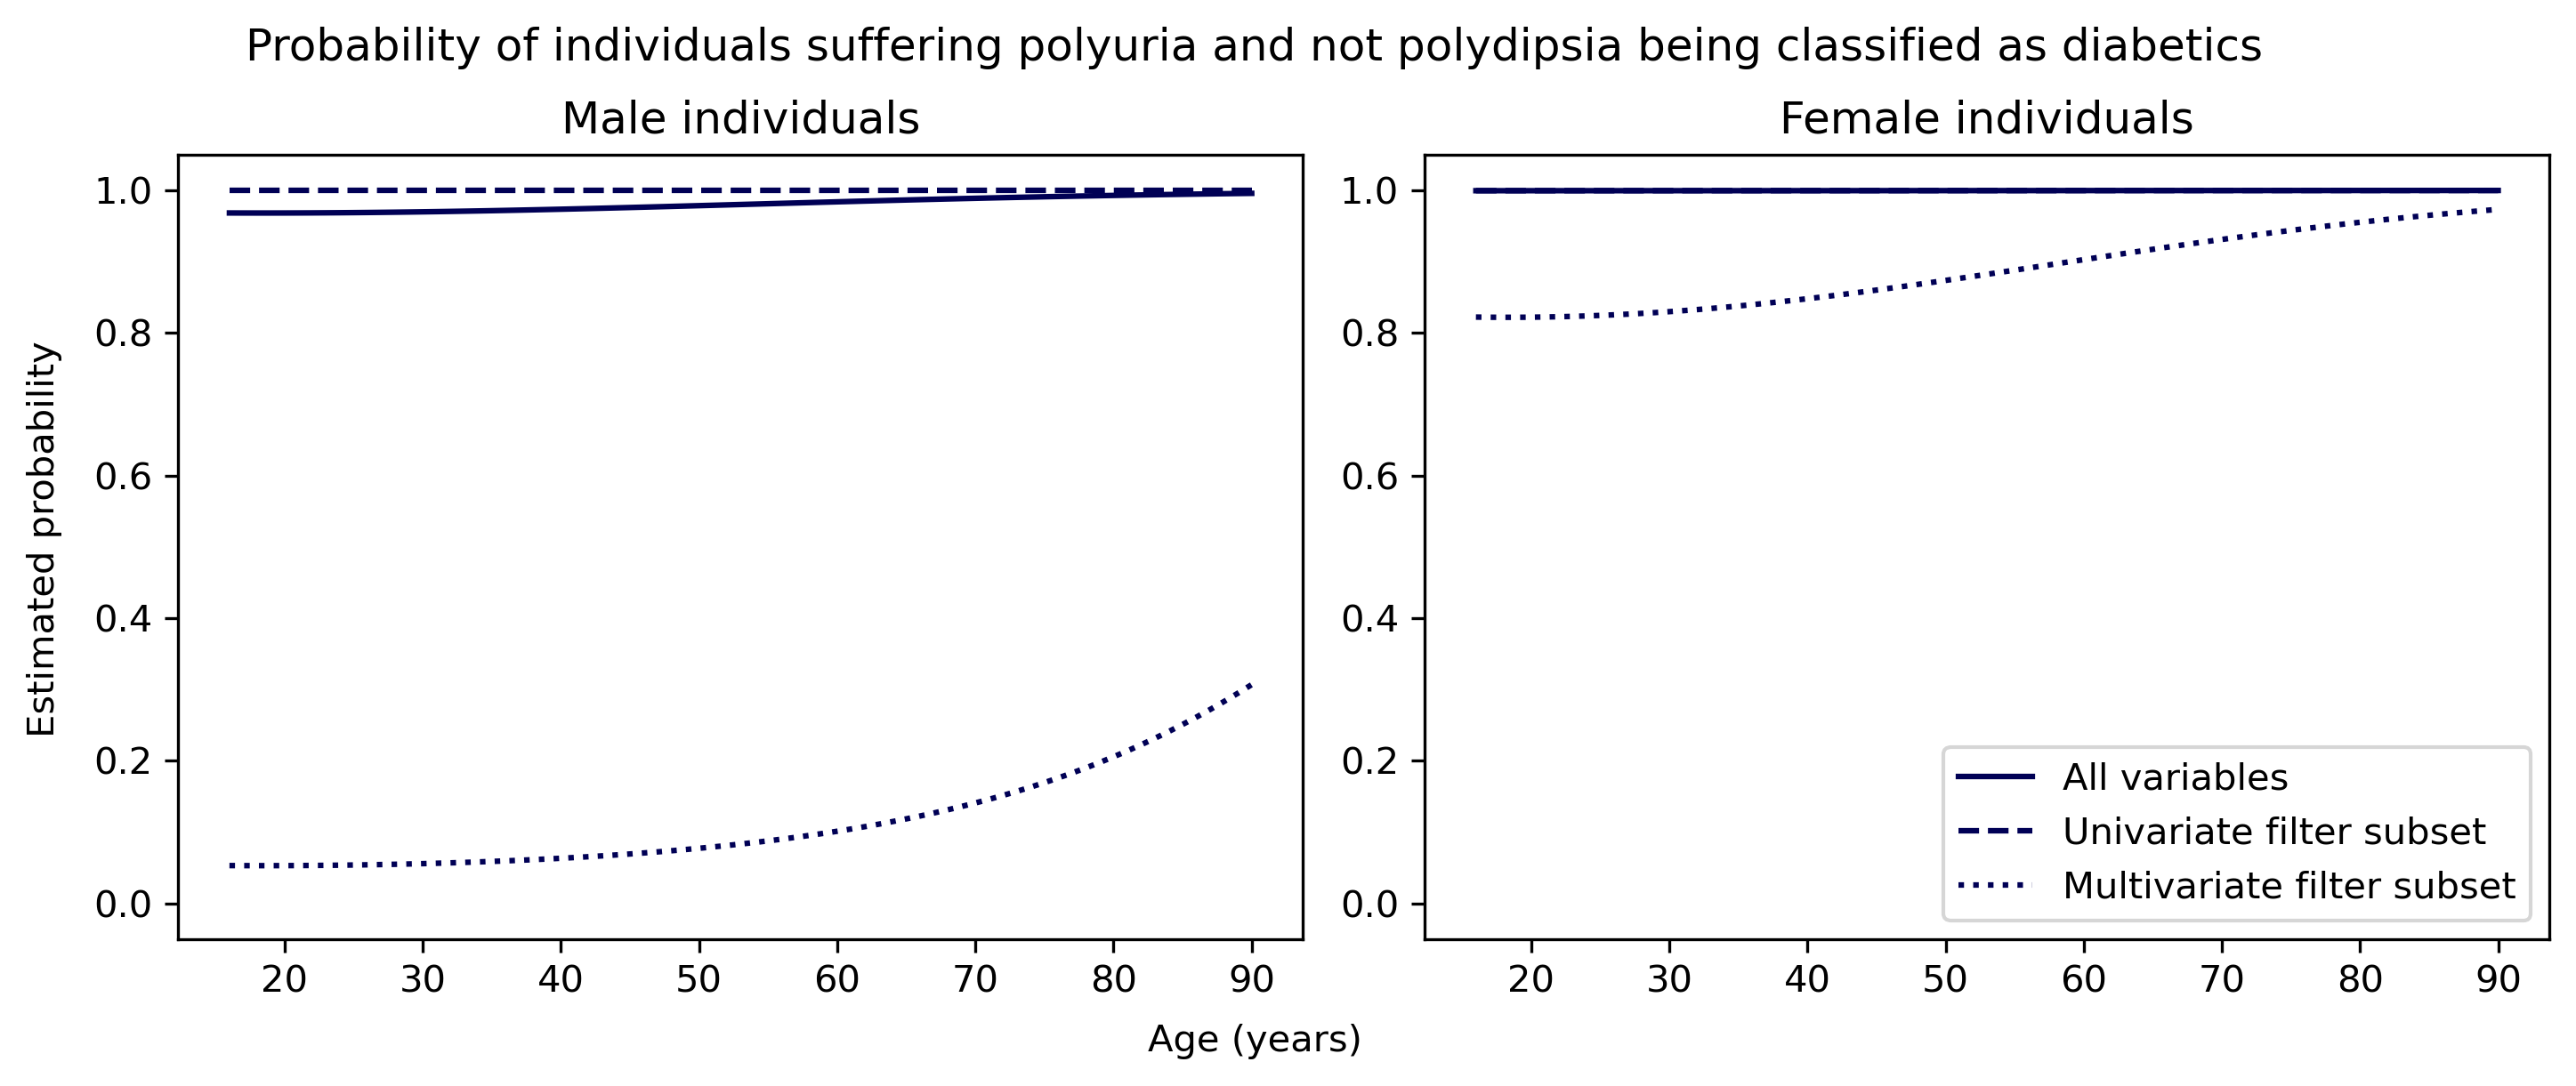

In [18]:
probs_ur_dip = []

testing = [[0, 1, 1, 0, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
            0.5]]

tasks = [[X_train, "All variables", "-", testing],
         [X_train_uni, "Univariate filter subset", "--", [[0, 1, 1, 0, 0.5]]],
         [X_train_multi, "Multivariate filter subset", ":", [[0,1,0,0.5,0.5]]]]

year_range = list(range(16,91))

fig, axs = plt.subplots(1, 2, figsize = (10, 4),  dpi=300)

for task in tasks:
    results = cross_validate(gnb, task[0], y_train, cv=10,
                                return_estimator = True)
    
    for sex in [[0, "-", "Female individuals"],[1, ".", "Male individuals"]]:
        probs = []
        for i in range(16,91):
            task[3][0][0] = i
            task[3][0][1] = sex[0]
            probs.append(results["estimator"][0].predict_proba(task[3])[0][1])
        axs[abs(sex[0]-1)].plot(year_range, probs, task[2], c= "#000055")
        axs[abs(sex[0]-1)].set_ylim([-0.050, 1.05])
        axs[abs(sex[0]-1)].set_title(sex[2])
        axs[1].legend(["All variables", "Univariate filter subset", "Multivariate filter subset"], loc = "lower right")

fig.text(0.04, 0.5, 'Estimated probability', va='center', rotation='vertical')
fig.text(0.5, 0.02, 'Age (years)', ha='center')
fig.suptitle("Probability of individuals suffering polyuria and not polydipsia being classified as diabetics", fontsize = 12)
fig.tight_layout(w_pad=1,rect=[0.05, 0.03, 1, 0.95])
fig.savefig("gnb.png")

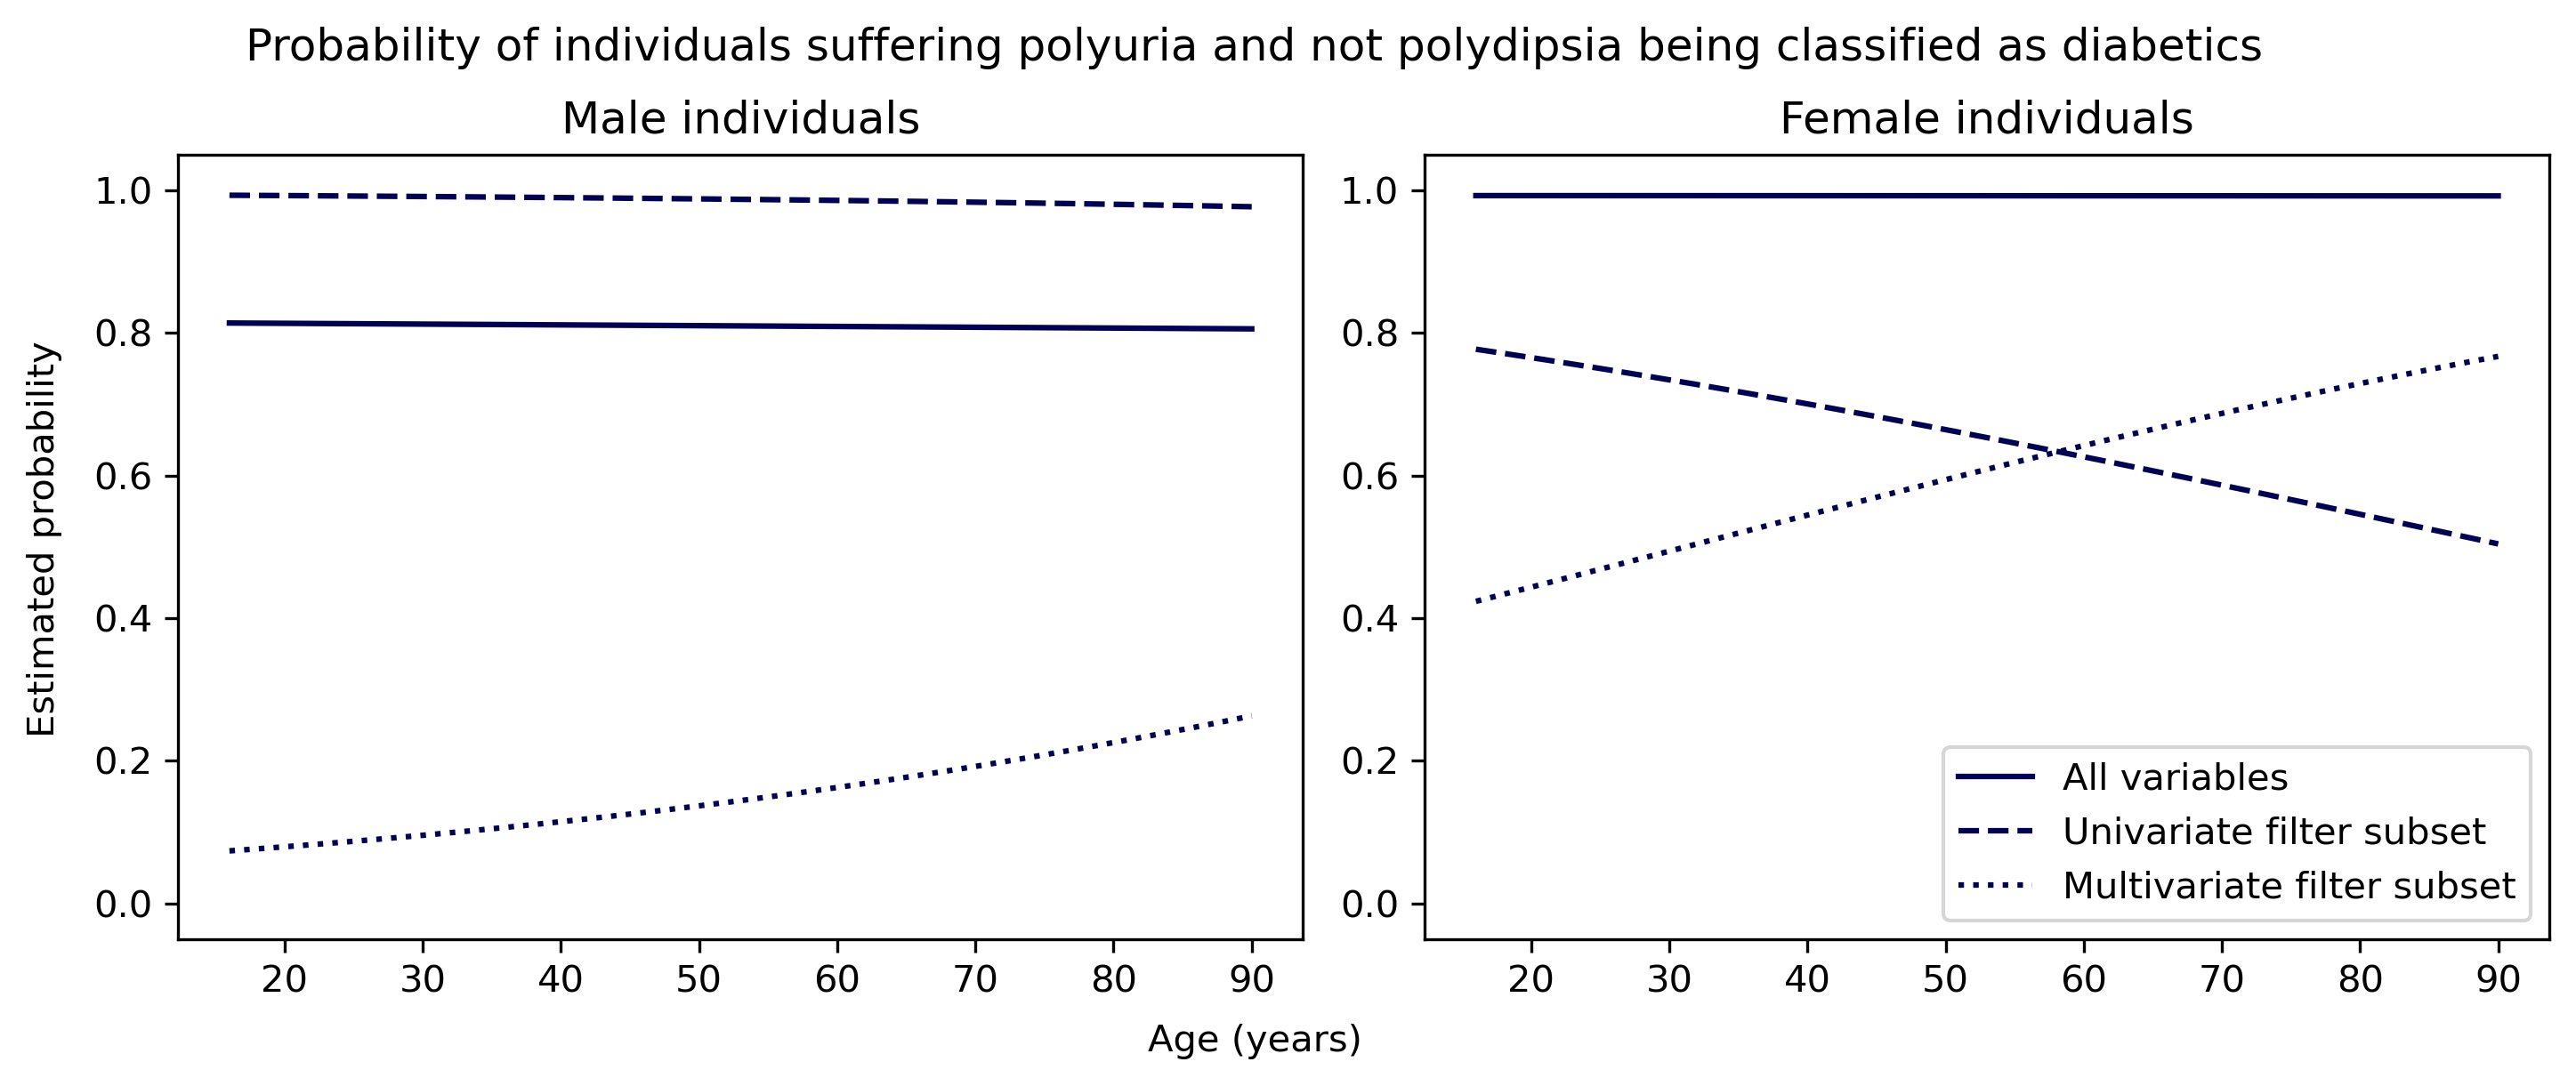

In [19]:
probs_ur_dip = []

testing = [[0, 1, 1, 0, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
            0.5]]

tasks = [[X_train, "All variables", "-", testing],
         [X_train_uni, "Univariate filter subset", "--", [[0, 1, 1, 0, 0.5]]],
         [X_train_multi, "Multivariate filter subset", ":", [[0,1,0,0.5,0.5]]]]

year_range = list(range(16,91))

fig, axs = plt.subplots(1, 2, figsize = (10, 4),  dpi=300)

for task in tasks:
    results = cross_validate(lda, task[0], y_train, cv=10,
                                return_estimator = True)
    
    for sex in [[0, "-", "Female individuals"],[1, ".", "Male individuals"]]:
        probs = []
        for i in range(16,91):
            task[3][0][0] = i
            task[3][0][1] = sex[0]
            probs.append(results["estimator"][0].predict_proba(task[3])[0][1])
        axs[abs(sex[0]-1)].plot(year_range, probs, task[2], c="#000055")
        axs[abs(sex[0]-1)].set_ylim([-0.050, 1.05])
        axs[abs(sex[0]-1)].set_title(sex[2])
        axs[1].legend(["All variables", "Univariate filter subset", "Multivariate filter subset"], loc = "lower right")

fig.text(0.04, 0.5, 'Estimated probability', va='center', rotation='vertical')
fig.text(0.5, 0.02, 'Age (years)', ha='center')
fig.suptitle("Probability of individuals suffering polyuria and not polydipsia being classified as diabetics", fontsize = 12)
fig.tight_layout(w_pad=1,rect=[0.05, 0.03, 1, 0.95])
fig.savefig("lda.png")

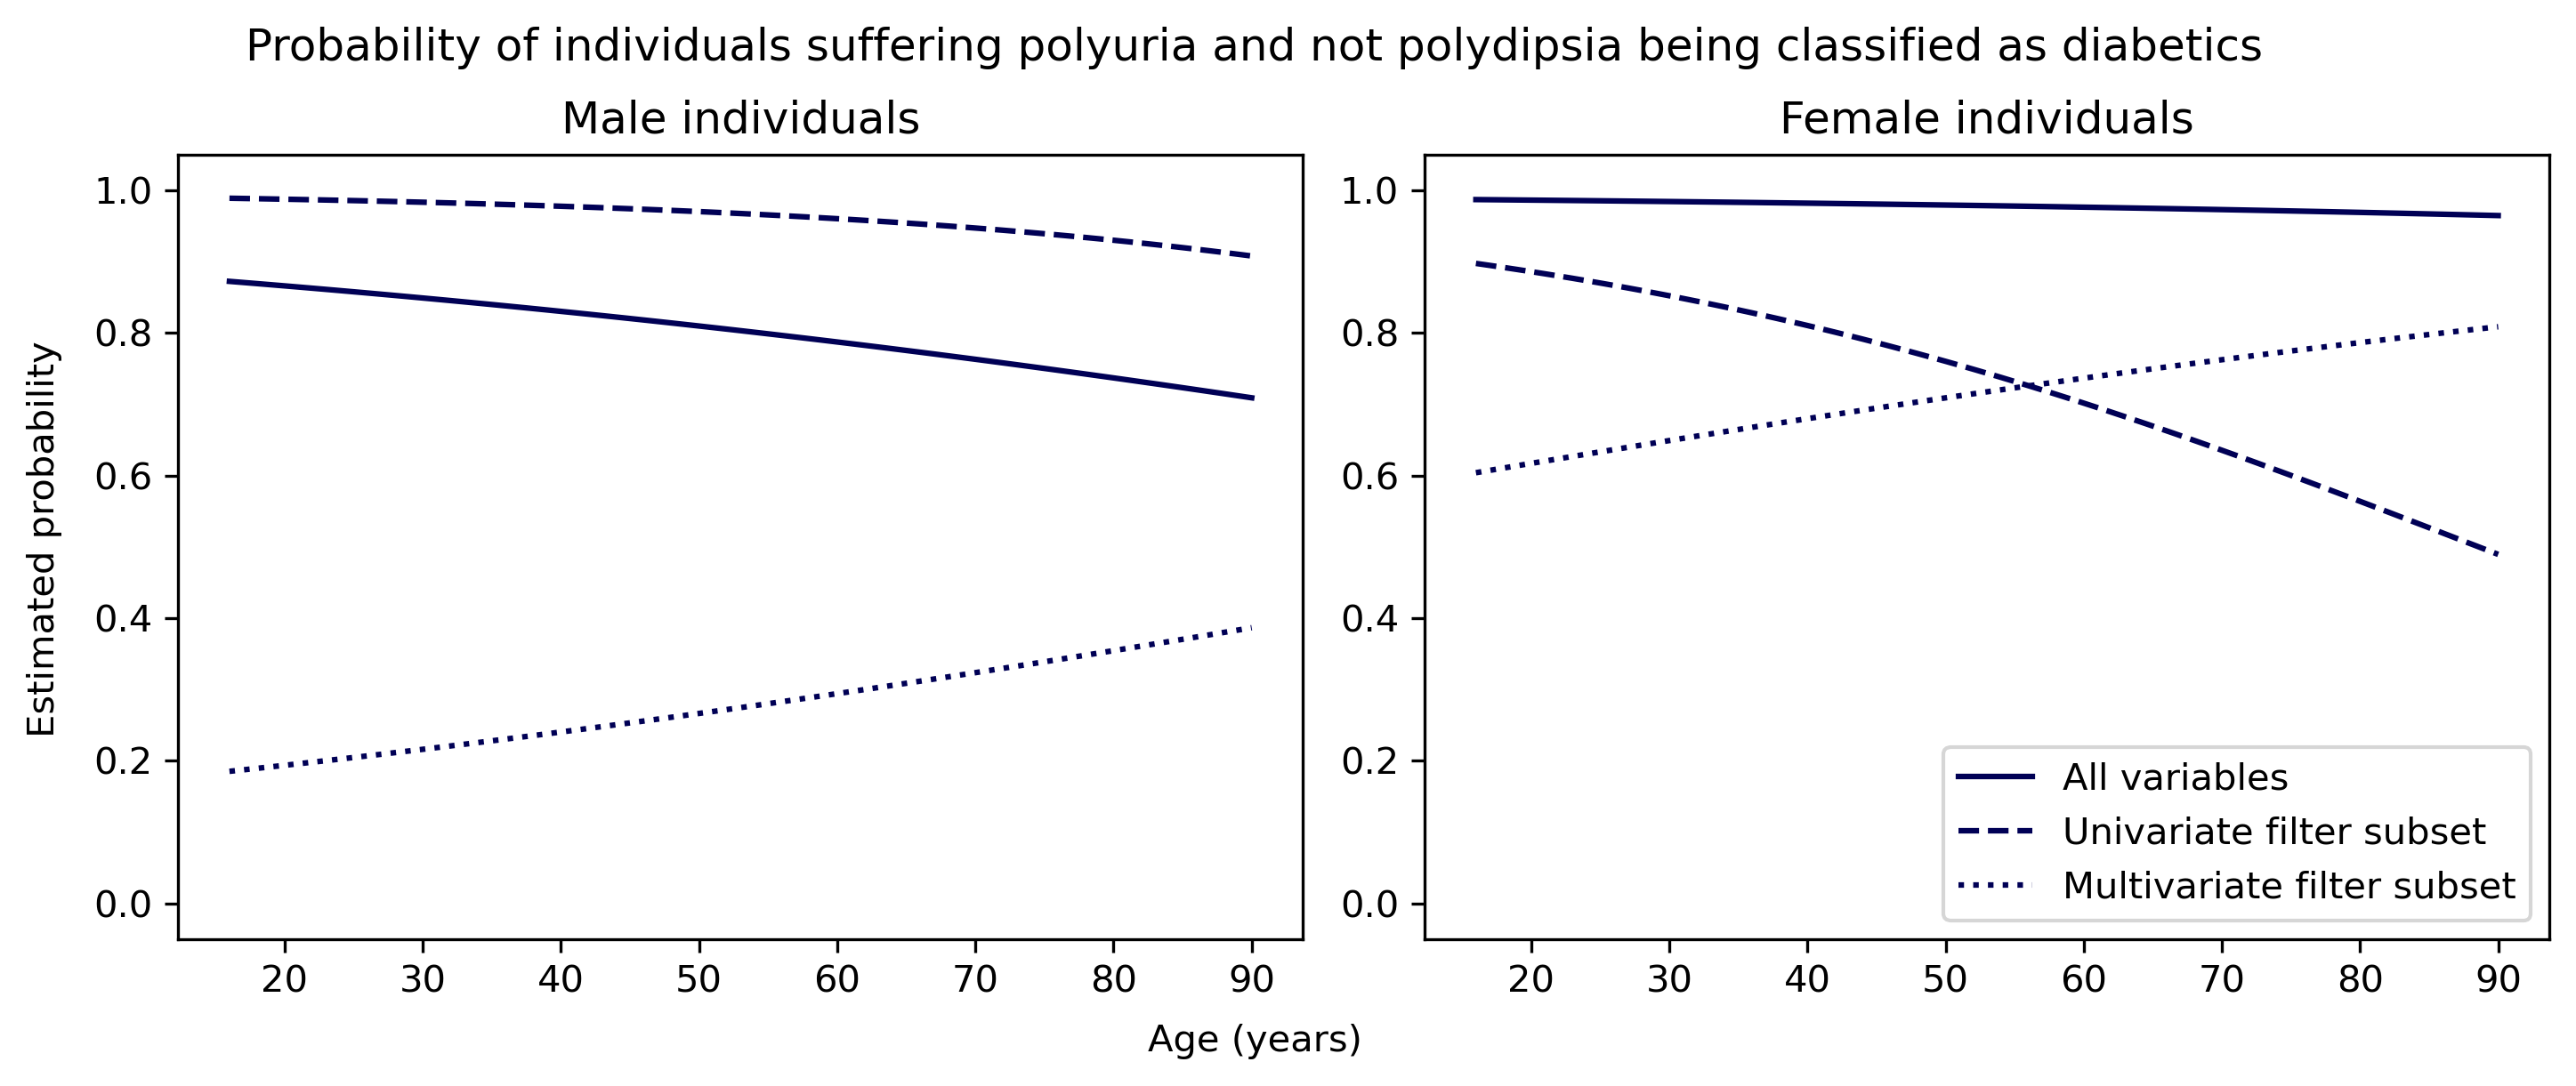

In [20]:
probs_ur_dip = []

testing = [[0, 1, 1, 0, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
            0.5]]

tasks = [[X_train, "All variables", "-", testing],
         [X_train_uni, "Univariate filter subset", "--", [[0, 1, 1, 0, 0.5]]],
         [X_train_multi, "Multivariate filter subset", ":", [[0,1,0,0.5,0.5]]]]

year_range = list(range(16,91))

fig, axs = plt.subplots(1, 2, figsize = (10, 4),  dpi=300)

for task in tasks:
    results = cross_validate(lr, task[0], y_train, cv=10,
                                return_estimator = True)
    
    for sex in [[0, "-", "Female individuals"],[1, ".", "Male individuals"]]:
        probs = []
        for i in range(16,91):
            task[3][0][0] = i
            task[3][0][1] = sex[0]
            probs.append(results["estimator"][0].predict_proba(task[3])[0][1])
        axs[abs(sex[0]-1)].plot(year_range, probs, task[2], c = "#000055")
        axs[abs(sex[0]-1)].set_ylim([-0.050, 1.05])
        axs[abs(sex[0]-1)].set_title(sex[2])
        axs[1].legend(["All variables", "Univariate filter subset", "Multivariate filter subset"], loc = "lower right")

fig.text(0.04, 0.5, 'Estimated probability', va='center', rotation='vertical')
fig.text(0.5, 0.02, 'Age (years)', ha='center')
fig.suptitle("Probability of individuals suffering polyuria and not polydipsia being classified as diabetics", fontsize = 12)
fig.tight_layout(w_pad=1,rect=[0.05, 0.03, 1, 0.95])
fig.savefig("lr.png")

In all these plots, we see that classifiers that consider only the subset of variables selected by multivariate filter have a very strange behaviour when comparing with the other two. This can be explained by the non-inclusion of Polyuria, which at first seemed a very informative attribute, in the best subset.

Finally, I have represented a randomly selected three from the Random forests classifier that takes into account only the five variables selected by univariate filter.

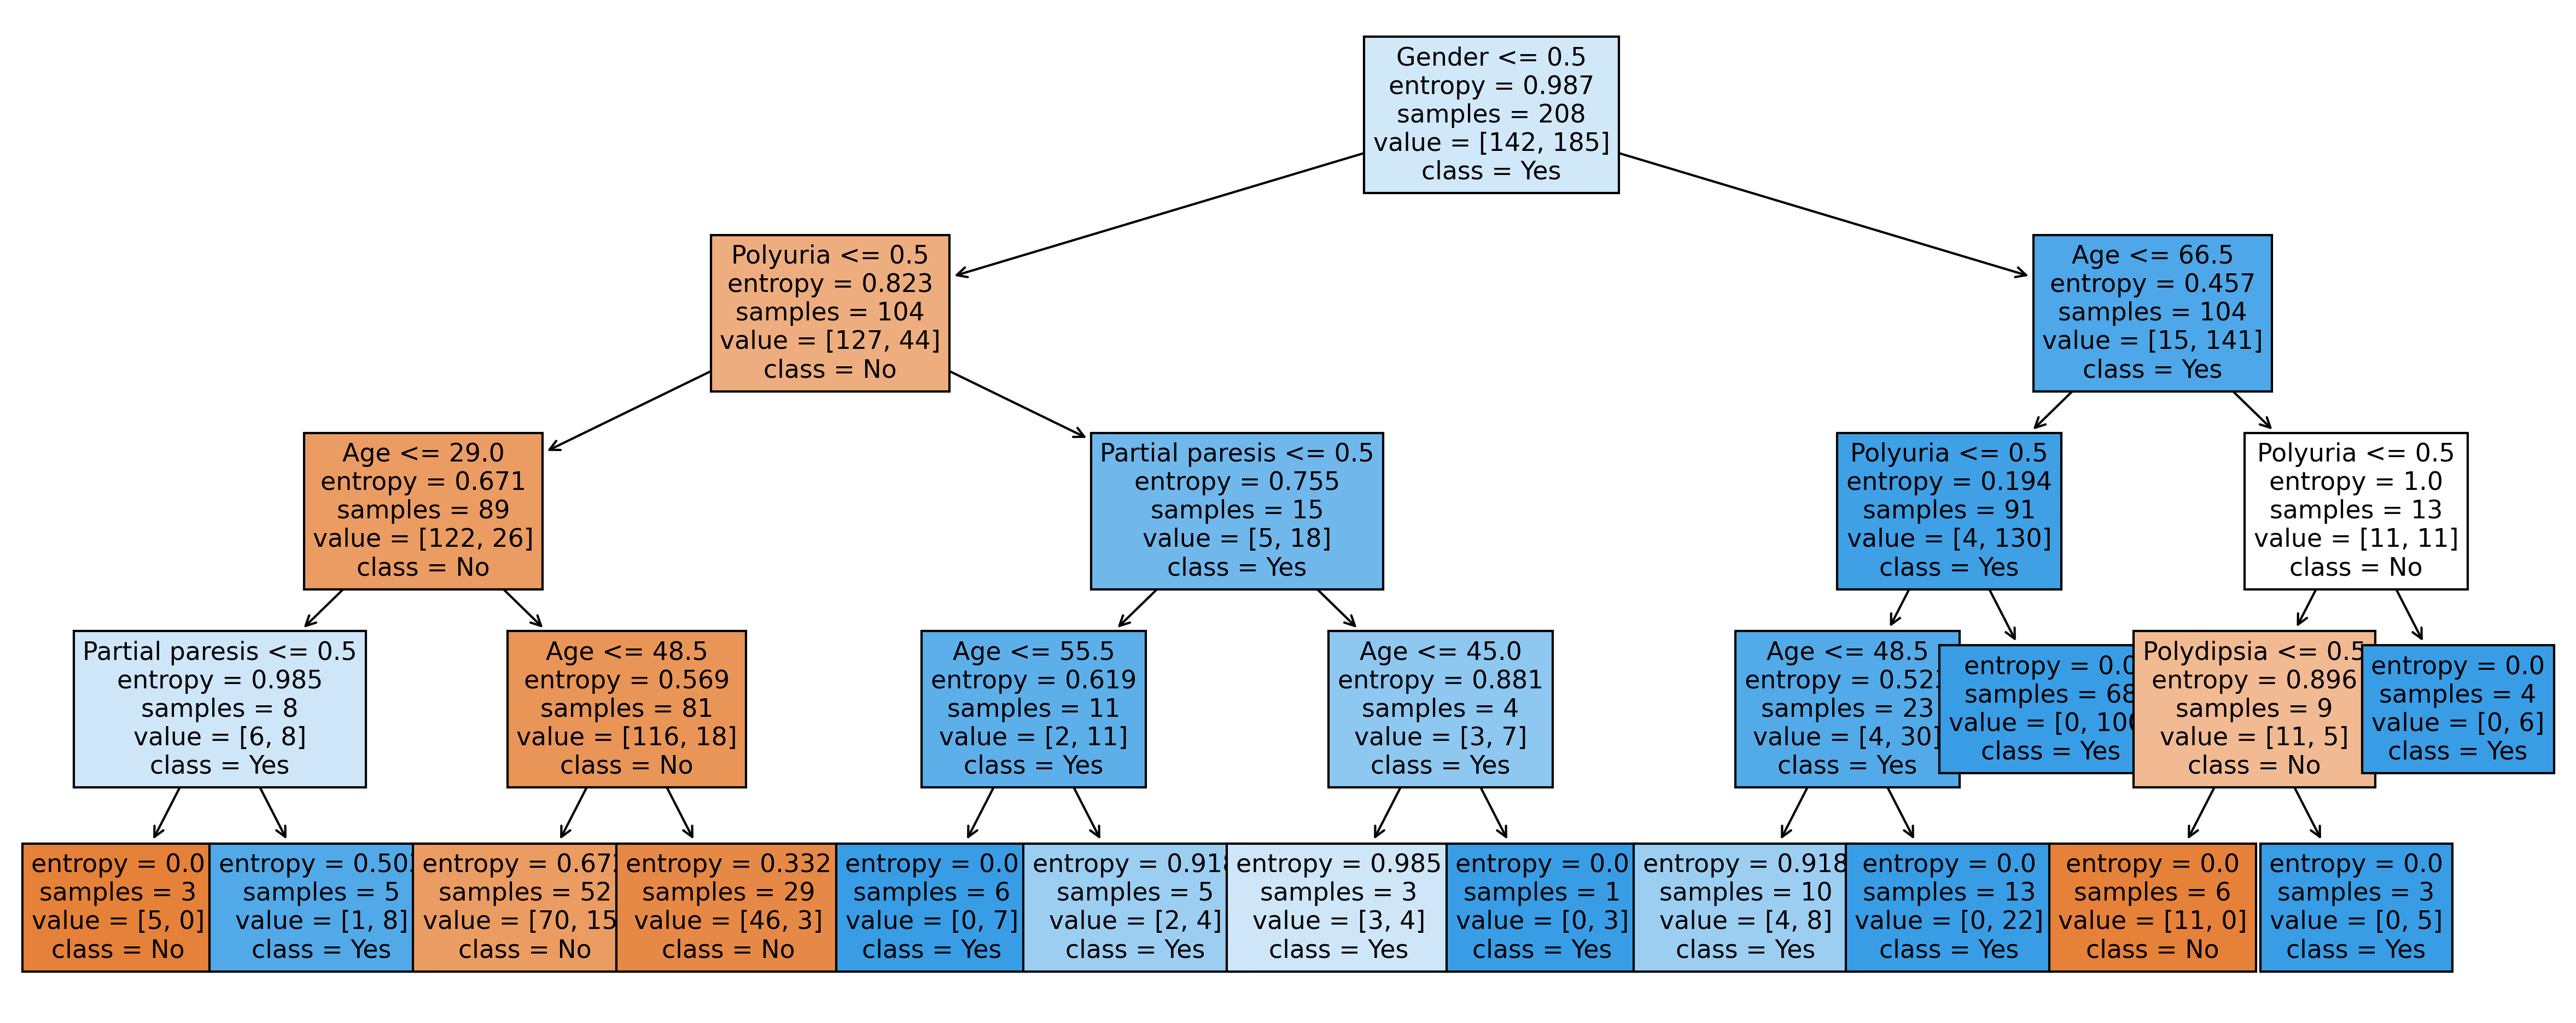

In [21]:
from sklearn import tree

train_col = ["Age", "Gender", "Polyuria", "Polydipsia", "Partial paresis"]
rf = RandomForestClassifier(max_depth=4, criterion = "entropy", random_state=0)
results = cross_validate(rf, X_train_uni, y_train, cv=10,
                        scoring=('accuracy', 'recall', 'f1'),
                        return_train_score=True, 
                        return_estimator = True)

fig, axs = plt.subplots(1, 1, figsize=(20,8), dpi=300)
tree.plot_tree(results["estimator"][2].estimators_[5], filled=True, fontsize =  11, feature_names=train_col, class_names = ["No", "Yes"])
fig.savefig("treeb.png")


And that's all, I hope you have enjoyed it!